In [1]:
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from specutils import Spectrum1D
import astropy.units as u

from kosmos.apextract import _gaus
import kosmos

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<IPython.core.display.Javascript object>


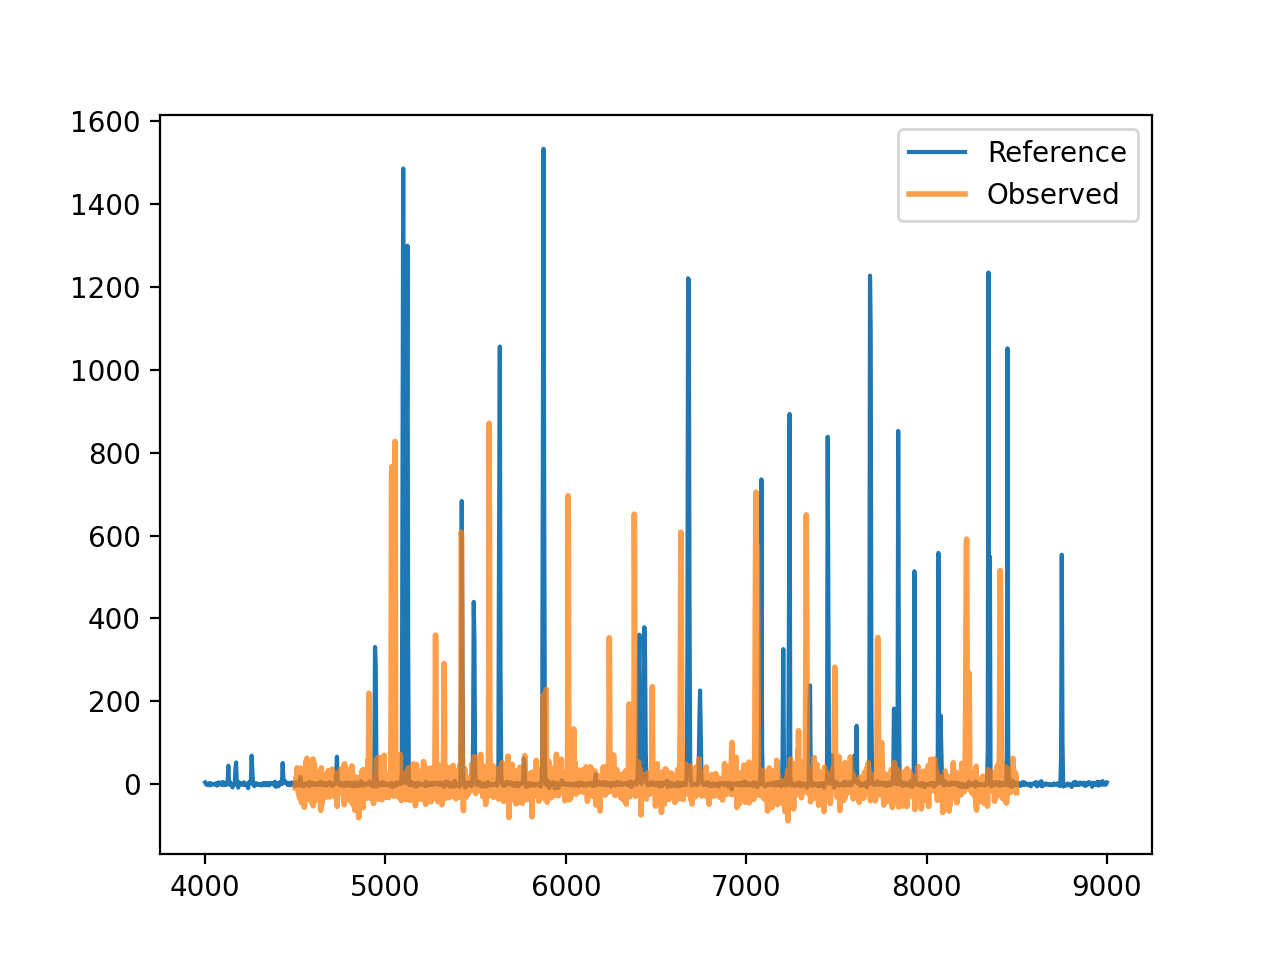

In [5]:
# generate some fake arc lamp spectra 

wav = np.append(np.logspace(np.log10(4500), np.log10(7000), 1024), 
               np.linspace(7001, 8500, 1024))

pix = np.arange(len(wav))

Nlines = 30
lines = np.random.random(size=Nlines)*4000 + 4500
peaks = np.random.random(size=Nlines) * 1000

flux = np.zeros(2048)
for k in range(Nlines):
    flux = flux + _gaus(wav, peaks[k], 0, lines[k], 2)

# do transformation for ref spectrum
flux2 = np.interp(np.linspace(4500,8500,2048), wav, flux)

# add some gaussian noise to the observation
flux = flux+np.random.normal(loc=0, scale=25, size=2048)

# Here's the TRUTH you would have on hand, either from observatory or a previous reduction
# it spans a larger wavelength range, and has a few extra random lines in it
wav_ref = np.linspace(4000,9000,1280)
flux_ref = np.interp(wav_ref, wav, flux2) * 2  # down-sample the library spectrum
flux_ref = flux_ref + np.random.normal(loc=0, scale=3, size=len(flux_ref))

# put some extra small lines in
elines = 10
for k in range(elines):
    flux_ref = flux_ref + _gaus(wav_ref, np.random.random(size=1)*100, 0, 
                        np.random.random(size=1)*5000+4000, 2)
# put at least 1 major line outside the observed spectrum too
flux_ref = flux_ref + _gaus(wav_ref, 555, 0, 8750, 2)


plt.plot(wav_ref, flux_ref, label='Reference')
# the observation is (pix, flux)
# and if you just linearly shift/scaled the trace into the wavelegnth range:
plt.plot(np.linspace(4500,8500,2048), flux, lw=2, alpha=0.75, label='Observed')
plt.legend()

ref = Spectrum1D(spectral_axis=wav_ref*u.AA, flux=flux_ref*u.adu/u.s)
arc = Spectrum1D(spectral_axis=np.arange(len(flux))*u.pixel, flux=flux*u.adu/u.s)

In [3]:
# the most basic way... I don't love the results though
# arc2 = kosmos.dtwalign(arc, ref, upsample=True, display=True, peak_interp=False)


<IPython.core.display.Javascript object>


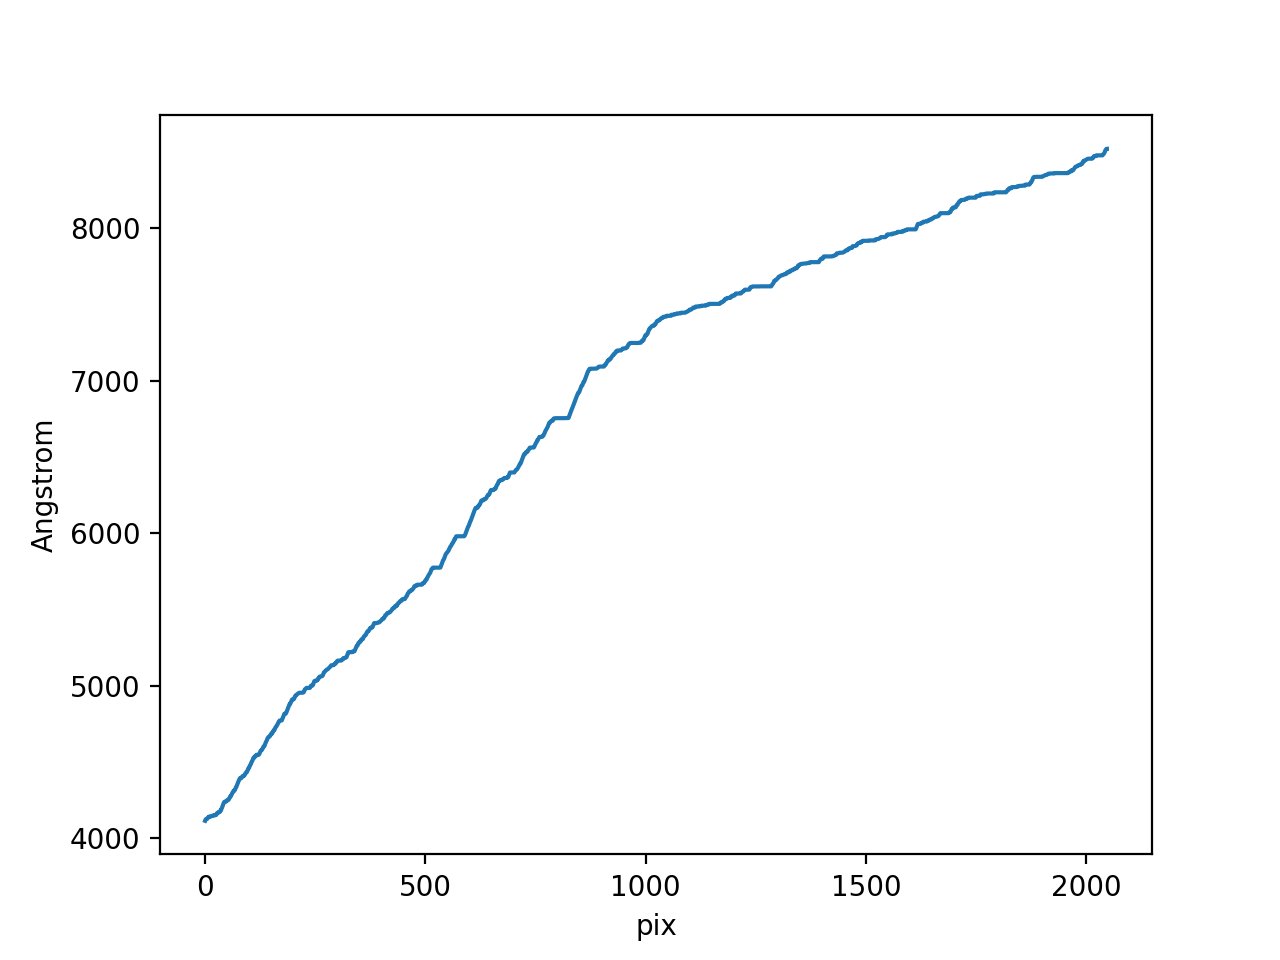

In [52]:
# this is a slightly more difficult use case, where it has to match the pattern AND the end points
# but if there's lots of info (many lines/features), it should be doable!

arc3 = kosmos.dtwalign(arc, ref, upsample=True, display=True, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=False, pthreshold=0.9)


<IPython.core.display.Javascript object>


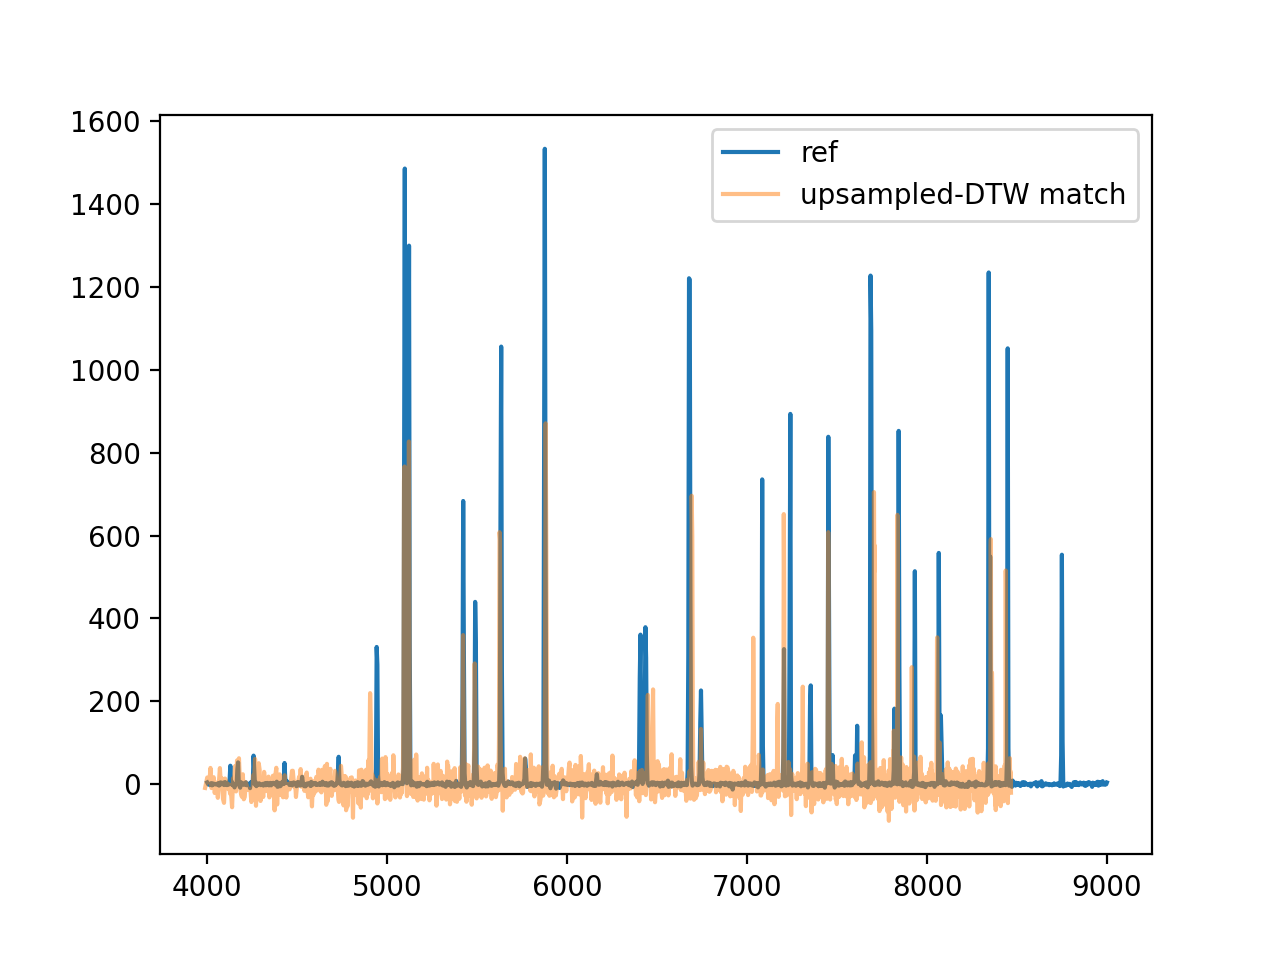

In [14]:
plt.plot(ref.spectral_axis.value, ref.flux.value, label='ref')
plt.plot(arc3.spectral_axis.value, arc3.flux.value, label='upsampled-DTW match', alpha=0.5)
plt.legend()
# plt.show()

In [18]:
# plt.plot(arc.spectral_axis.value, np.gradient(arc.flux.value)/np.nanmean(arc.flux.value), label='ref')
# plt.plot(arc.spectral_axis.value, np.gradient(arc.flux.value,2)/np.nanmean(arc.flux.value), label='ref')



<IPython.core.display.Javascript object>


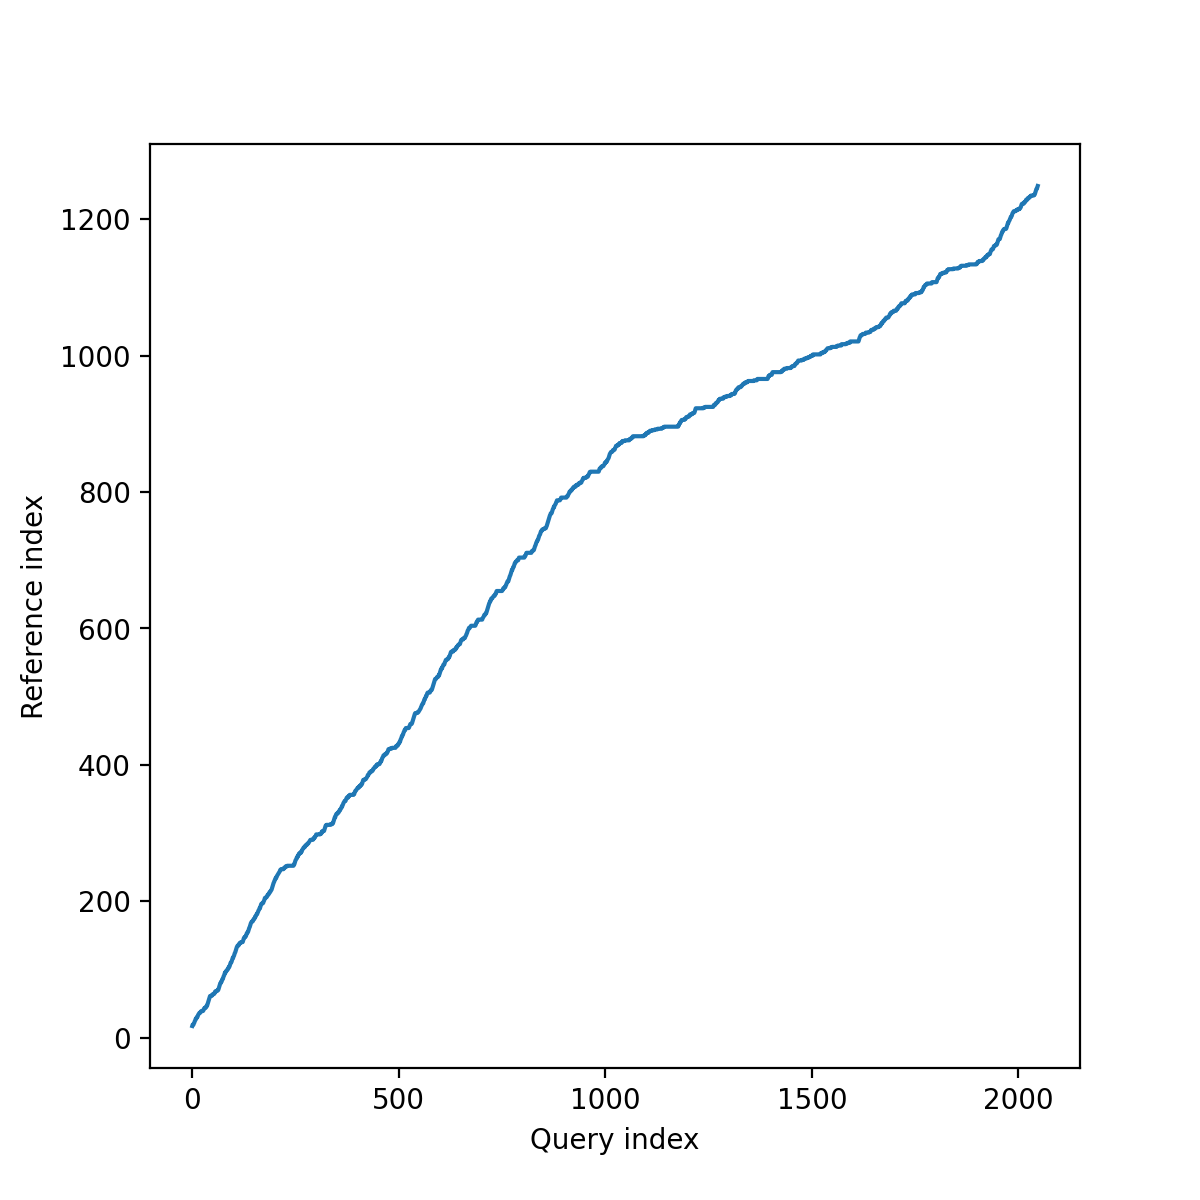

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [19]:
# this is what we're doing now:
import dtw
alignment = dtw.dtw(arc.flux.value / np.nanmean(arc.flux.value),
                    ref.flux.value / np.nanmean(ref.flux.value),
                    keep_internals=True, step_pattern='asymmetric', open_begin=True, open_end=True,)
alignment.plot()

In [20]:
# import dtw
# alignment = dtw.dtw(np.gradient(arc.flux.value,2) / np.nanmean(arc.flux.value),
#                     np.gradient(ref.flux.value,2) / np.nanmean(ref.flux.value),
#                     keep_internals=True, step_pattern='asymmetric', open_begin=True, open_end=True,)
# alignment.plot()

In [14]:
# Eric Bellm and I think: it would be cool to quantify (or even just guestimate) 
# what the wavelength uncertainty is here

In [8]:
# plt.plot(arc3.wavelength.value)


# spl = UnivariateSpline(np.arange(len(arc3.wavelength.value)), arc3.wavelength.value, 
#                        ext=0, k=3, 
#                        s=1e6
#                       )
# w_new = spl(np.arange(len(arc3.wavelength.value)))

# plt.plot(w_new)

<IPython.core.display.Javascript object>


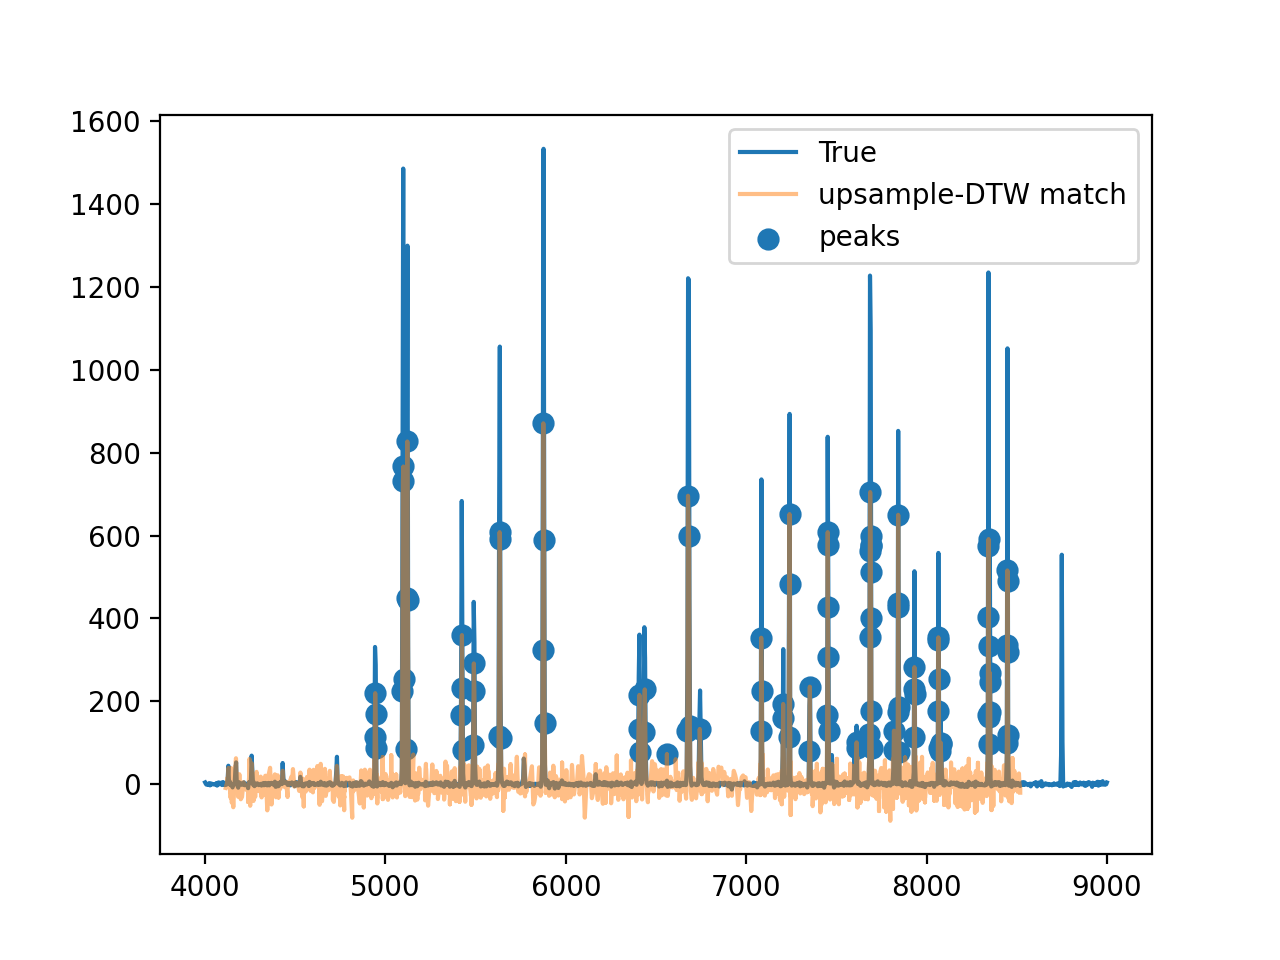

In [22]:
plt.plot(ref.spectral_axis.value, ref.flux.value, label='True')
# plt.plot(arc2.spectral_axis.value, arc2.flux.value, label='symmetric1', alpha=0.5)
plt.plot(arc3.spectral_axis.value, arc3.flux.value, label='upsample-DTW match', alpha=0.5)
# plt.plot(w_new, arc3.flux.value, label='DTW+Spline Soln', alpha=0.5)

pks = np.where((arc3.flux.value >= np.percentile(arc3.flux.value, 95)))[0]
plt.scatter(arc3.spectral_axis.value[pks], arc3.flux.value[pks], label='peaks', lw=2)
plt.legend()

In [44]:
# len(arc3.wavelength.value)*300
# 1e3 / len(pks)
1e4 / len(arc3.wavelength.value)

4.8828125

<IPython.core.display.Javascript object>


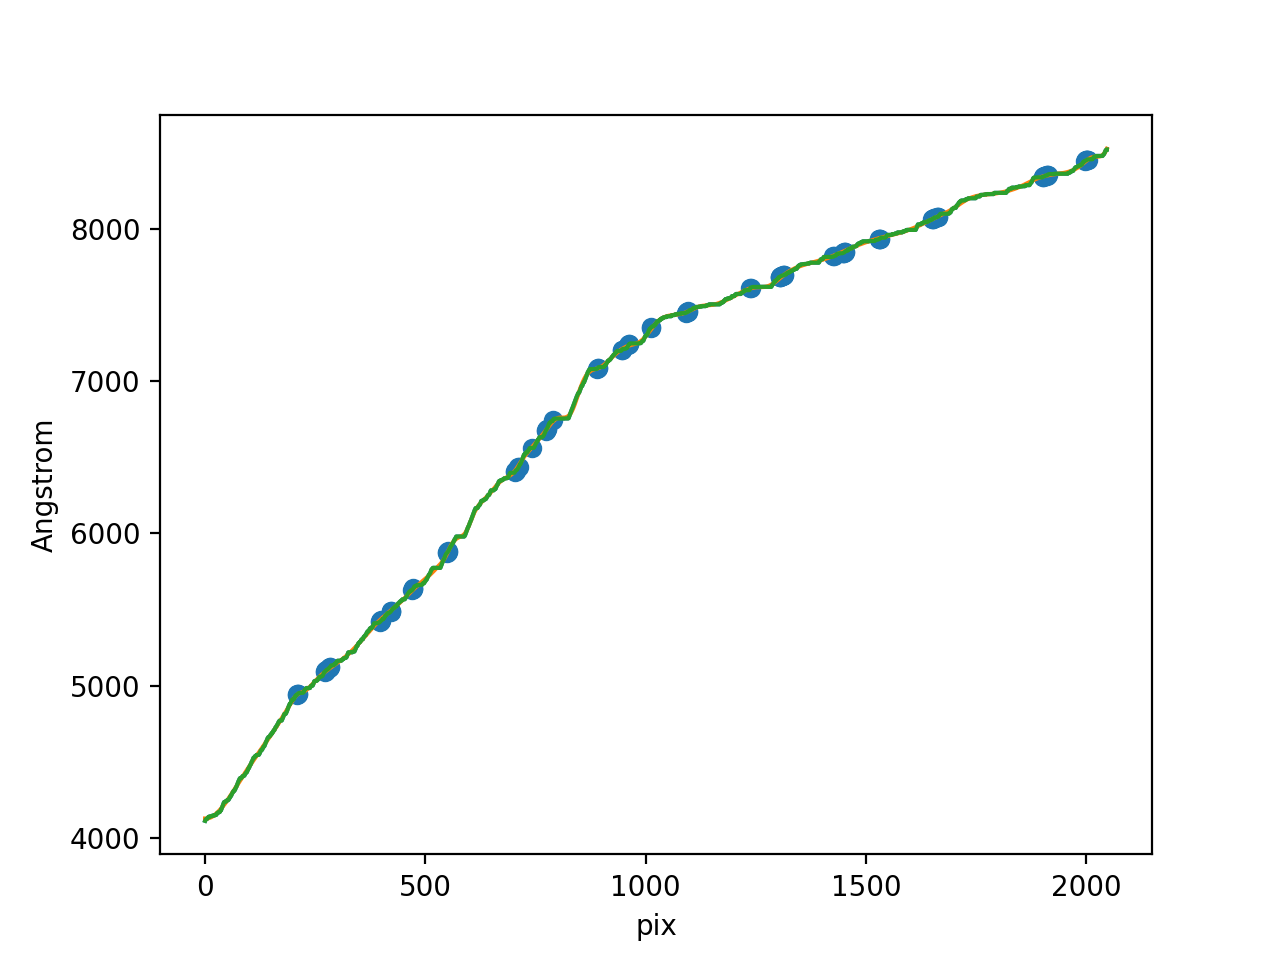

In [48]:
from scipy.interpolate import UnivariateSpline

plt.plot(arc3.wavelength.value)

plt.scatter(pks, arc3.wavelength.value[pks])

# spl = UnivariateSpline(pks, arc3.wavelength.value[pks], ext=0, k=3, s=len(pks)*10)
spl = UnivariateSpline(np.arange(len(arc3.wavelength.value)), arc3.wavelength.value, ext=0, k=3, 
                       s=1e4)
w_new = spl(np.arange(len(arc3.wavelength.value)))

plt.plot(w_new)

<IPython.core.display.Javascript object>


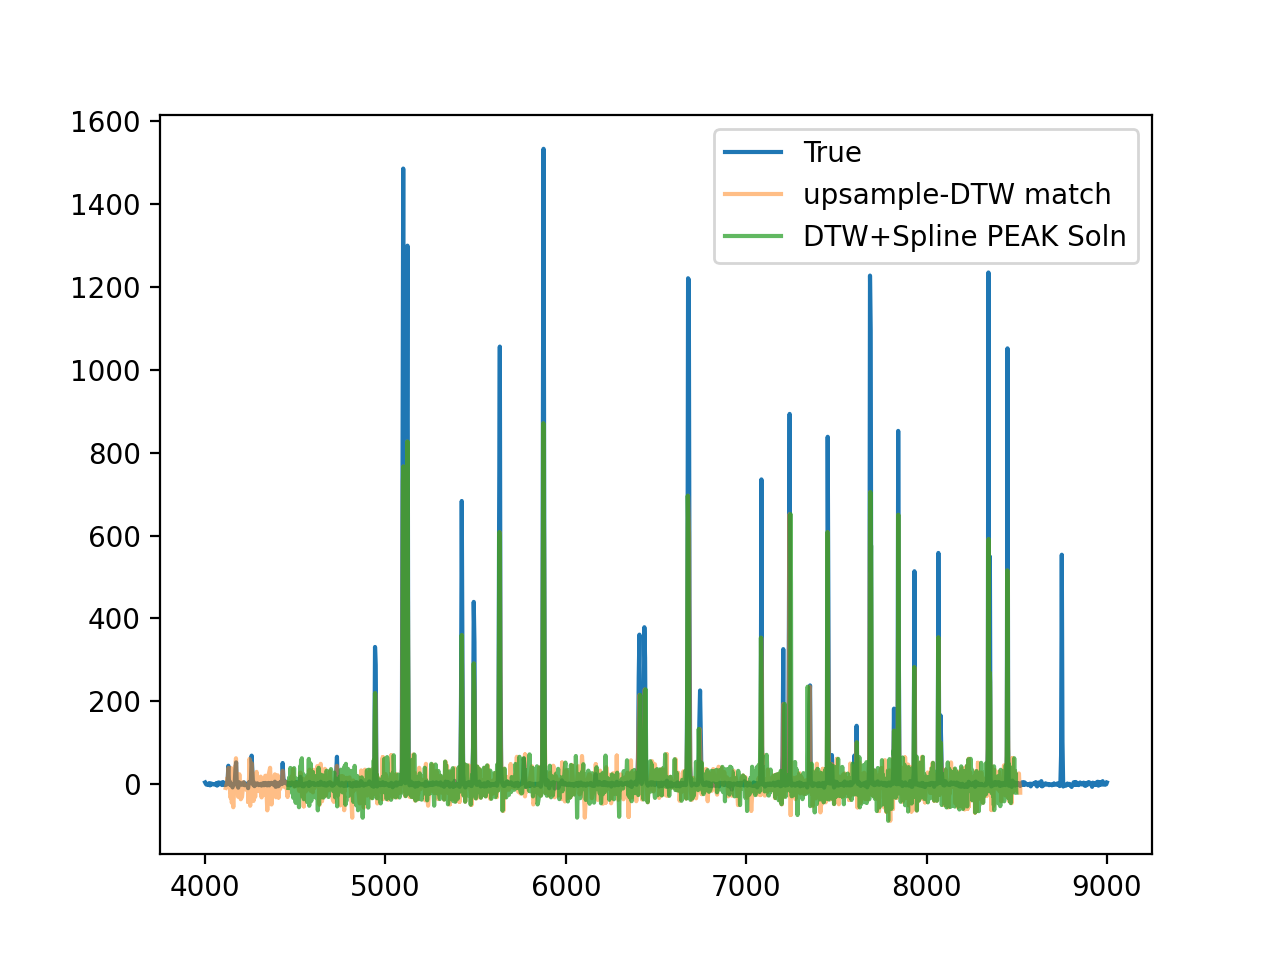

In [42]:
plt.plot(ref.spectral_axis.value, ref.flux.value, label='True')
# plt.plot(arc2.spectral_axis.value, arc2.flux.value, label='symmetric1', alpha=0.5)
plt.plot(arc3.spectral_axis.value, arc3.flux.value, label='upsample-DTW match', alpha=0.5)
plt.plot(w_new, arc3.flux.value, label='DTW+Spline PEAK Soln', alpha=0.75)
plt.legend()

In [ ]:
# i think its time to try working on real data to understand how bent/non-linear this needs to realistically be!